In [27]:
import pandas as pd
from catboost import CatBoostClassifier
import lightgbm as lgb
import numpy as np
import os
# from sklearn.cross_validation import KFold
from sklearn.model_selection import KFold
pd.options.display.max_columns = 100
os.listdir('../input')

['train',
 'test',
 'breed_labels.csv',
 'train_sentiment',
 'test_sentiment',
 'test_metadata',
 'train_images',
 'train_metadata',
 'state_labels.csv',
 'color_labels.csv',
 'test_images']

In [34]:
# train = pd.read_csv('../train/train.csv')
train = pd.read_csv('../input/train/train.csv')
print(train.shape)
train.head()

(14993, 24)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
Type             14993 non-null int64
Name             13736 non-null object
Age              14993 non-null int64
Breed1           14993 non-null int64
Breed2           14993 non-null int64
Gender           14993 non-null int64
Color1           14993 non-null int64
Color2           14993 non-null int64
Color3           14993 non-null int64
MaturitySize     14993 non-null int64
FurLength        14993 non-null int64
Vaccinated       14993 non-null int64
Dewormed         14993 non-null int64
Sterilized       14993 non-null int64
Health           14993 non-null int64
Quantity         14993 non-null int64
Fee              14993 non-null int64
State            14993 non-null int64
RescuerID        14993 non-null object
VideoAmt         14993 non-null int64
Description      14981 non-null object
PetID            14993 non-null object
PhotoAmt         14993 non-null float64
AdoptionSpe

In [38]:
test = pd.read_csv('../input/test/test.csv')
test.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,1,Puppy,2,307,0,1,1,0,0,2,2,2,2,2,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,"Puppy is calm for a young dog, but he becomes ...",378fcc4fc,3.0
1,2,London,24,266,0,1,2,7,0,2,1,1,1,1,1,1,0,41326,4475f31553f0170229455e3c5645644f,0,Urgently seeking adoption. Please contact for ...,73c10e136,1.0
2,2,Snowball,20,266,0,2,7,0,0,2,1,1,1,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,Snowball... doesn't look so good (she is healt...,72000c4c5,1.0
3,2,Malibu,5,266,252,2,1,6,7,2,1,1,1,1,1,1,100,41326,4475f31553f0170229455e3c5645644f,0,"Malibu: Female, Local Mix, 4-5 months, vaccina...",e147a4b9f,1.0
4,1,Lala Girl,6,307,0,2,1,2,7,2,1,1,1,1,1,1,150,41326,4475f31553f0170229455e3c5645644f,0,LALA! That's my name. I'm a 6 month old girl d...,43fbba852,1.0


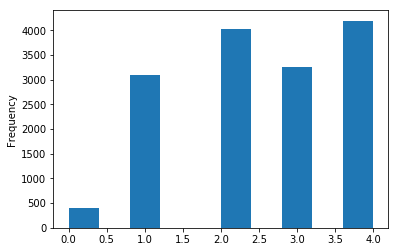

In [39]:
train.AdoptionSpeed.plot('hist');

In [78]:
def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)


def train_model(x_train, y_train, train_index, test_index, model_type, params = None):
    if model_type == 'cat':
        model = CatBoostClassifier(iterations=1000).fit(x_train, y_train)
    if model_type == 'lgb':
        train_data = lgb.Dataset(x_train[train_index], label = y_train[train_index])
        model = lgb.train(params, train_data, num_boost_round= 5000,)
        
        y_pred = model.predict(x_train[test_index]).argmax(1)
        print(y_pred.shape)
        score = quadratic_weighted_kappa(y_train[test_index], y_pred)
        
    return model, score 

def submit(test_frame, y_pred, file_name,):
    frame = pd.DataFrame({'PetID': test_frame.PetID, 'AdoptionSpeed': y_pred})
    frame.to_csv(path_or_buf=file_name, index=False)
    return

In [79]:
#Имя животного как обработать
cols_to_used = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2','Color3', 'MaturitySize',
                'FurLength','Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 
                'VideoAmt',	'PhotoAmt']
x_train = train[cols_to_used].values
y_train = train.AdoptionSpeed.values

x_test = test[cols_to_used]
# print(x_test)
print('Тест ', x_test.shape)

Тест  (3948, 19)


In [80]:
y = [1,2,3,4]
y_p = [2,4,2,1]
quadratic_weighted_kappa(y, y_p)

-0.5

In [81]:
params = {'num_leaves': 256,
        #  'min_data_in_leaf': 60,
         'objective': 'multiclass',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 5,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
        #  "lambda_l1": 0.1,
         # "lambda_l2": 0.1,
         "random_state": 42,          
         "verbosity": -1,
         "num_class": 5}
kappa_score = []
kf = KFold(5, shuffle= True)
for train_index, test_index in kf.split(x_train):
    model, score = train_model(x_train, y_train, train_index, test_index, model_type = 'lgb',params = params)
    kappa_score += [score]
    print(score)
# model = train_model(x_train, y_train, 'lgb', params)

(2999,)
0.32387449357000386
(2999,)
0.33287977926231416
(2999,)
0.28711252133702136
(2998,)
0.314202338632529
(2998,)
0.29138920176610683


In [82]:
print('mean = {} +/- {}'.format(np.mean(kappa_score),np.std(kappa_score)))

mean = 0.30989166691359504 +/- 0.01790969196307786


In [77]:
print('mean = {} +/- {}'.format(np.mean(kappa_score),np.std(kappa_score)))

mean = 0.32520987009609925 +/- 0.013086378660984579


In [ ]:
y_pred = model.predict(x_test).argmax(1)

In [ ]:
y_pred.shape

In [ ]:
y_pred[0]

In [ ]:
submit(test,y_pred,'submit.csv')